<div style="background-color:#3b5d91; color:#f7faff; padding:30px; border-radius:50px; max-width:1000px; margin:right;">

# Data Exploration & Prepration

</div>


<div style="background-color:#ddecfc; color:#100; background-color:#eaf4ff; color:#111; padding:30px; border-radius:50px; max-width:1000px; margin:right;">

<font color="Navy">


In this section, we will explore our raw dataset files obtained from Kaggle, titled “Credit Card Fraud Mega Dataset” by Karthik Gangula (2023), to understand their structure, column types, and potential data quality issues such as **missing values**, **duplicates**, or **inconsistencies**, **dataoverlaps** before performing any merge operations.

<br>
<u>The Data set includes 2 primary tables:</u>

1. **transactions.csv** :
    - Contains detailed credit card transaction records, including transaction amount, timestamp, merchant category, and identifiers
2. **fraud_details.csv** :
    - Contains fraud-related flags and metadata corresponding to transactions.

</br>

</font>
</div>


In [2]:
import sys
print(sys.executable)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings
from geopy.distance import geodesic

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\credit-card-fraud-detection-model-FZHIqfLr-py3.13\Scripts\python.exe


### <font color = navy > <u> Data load: </u></font>

In [ ]:
transactions_df = pd.read_csv("C:/Users/User/Documents/GitHub/Credit_Card_Fraud_Detection_Model/data/credit_card_fraud.csv", index_col=0) #first column is index
customers_df = pd.read_csv("C:/Users/User/Documents/GitHub/Credit_Card_Fraud_Detection_Model/data/customers.csv", sep="|")

In [ ]:
print(transactions_df.shape)
print(customers_df.shape)

<div style="background-color:#f4f9fe ; color:#200; padding:30px; border-radius:50px;max-width:1200px; margin:left;">

The transaction_df has 34 million rows. Initial loading of both tables took about 6-12 minutes. <br>
To ensure smoother experimentation and reproducibility:
- lets store the datasets as Pickle (.pkl) files for quick pull (incase of kernel resets)
</br>

</div>

## <font color='Navy'> <h3>🔷 <u> Data Load & Prep </u></h3>

In [ ]:
# Save once (binary format)
transactions_df.to_pickle("transactions.pkl")
customers_df.to_pickle("customers.pkl")
warnings.filterwarnings('ignore')


In [2]:
#Quick load :
transactions_df = pd.read_pickle("transactions.pkl")
customers_df = pd.read_pickle("customers.pkl")

## <font color='Navy'> <h3>🔷 <u> Functions </u></h3>

In [3]:
def compare_columns(df1, name1, df2, name2):
    """
    Compares columns between two DataFrames.
    Prints:
    1. Common columns and their data types in both datasets.
    2. Columns unique to each dataset.
    """
    set1, set2 = set(df1.columns), set(df2.columns)
    common = set1.intersection(set2)
    only_in_1 = set1 - set2
    only_in_2 = set2 - set1
    
    print("="*60)
    print("🔹 Common Columns with Data Types")
    if common:
        comparison = {
            "Column": [],
            f"{name1} dtype": [],
            f"{name2} dtype": []
        }
        for col in sorted(common):
            comparison["Column"].append(col)
            comparison[f"{name1} dtype"].append(df1[col].dtype)
            comparison[f"{name2} dtype"].append(df2[col].dtype)
        result = pd.DataFrame(comparison)
        print(result.to_string(index=False))
    else:
        print("No common columns found.")

    print("\n" + "="*60)
    print(f"🔹 Columns only in {name1}:")
    if only_in_1:
        print(sorted(list(only_in_1)))

    else:
        print("No unique columns found.")
    
    print("\n" + "="*60)
    print(f"🔹 Columns only in {name2}:")
    if only_in_2:
        print(sorted(list(only_in_2)))
    else:
        print("No unique columns found.")
    print("="*60)

    return common, only_in_1, only_in_2


In [4]:
def unique_values_report(df, name, max_rows=20):
    """
    Prints number of unique values for each column in a DataFrame.
    Shows top 'max_rows' columns sorted by uniqueness.
    """
    uniques = df.nunique().sort_values(ascending=False).reset_index()
    uniques.columns = ["Column", "Unique Values"]
    
    print(f"\n🔹 Unique Value Report for {name} (showing top {max_rows}):")
    print(uniques.head(max_rows).to_string(index=False))
    


In [5]:
def clean_punc(col):
    return (
        col.str.lower()  # lowercase
           .str.replace(r"[^a-z0-9\s]", "", regex=True)  # remove special chars
           .str.strip()  # remove leading/trailing spaces
    )



In [6]:
def column_summary(df):
    summary = pd.DataFrame({
        'count': df.shape[0],
        'nulls': df.isnull().sum(),
        'nulls%': df.isnull().mean() * 100,
        'cardinality': df.nunique(),
        'dtype': df.dtypes
    })
    return summary


In [7]:
def check_case_duplicates(df, column):
    """
    Checks if a column has values that differ only by letter case.
    Returns True if normalization (lower/upper) is recommended.
    """
    original_unique = set(df[column].dropna().unique())
    normalized_unique = set(df[column].dropna().str.lower().unique())
    
    # If sizes differ → case duplicates exist
    if len(original_unique) != len(normalized_unique):
        print(f"⚠️ Column '{column}' has case duplicates.")
        diff = len(original_unique) - len(normalized_unique)
        print(f"   → {diff} duplicate categories caused by case.")
        return True
    else:
        print(f"✅ Column '{column}' has no case duplicates.")
        return False


In [8]:
def check_column_specials(df, column, sample_size=50000, sample=5):
    """
    Checks one column for punctuation or special characters.
    Uses a sample for speed on large datasets.
    
    Parameters:
    - df: pandas DataFrame
    - column: column name (string)
    - sample_size: number of rows to sample
    - sample: number of example values to display if issues are found
    """
    # Take a sample for speed
    df_sample = df[column].dropna().sample(
        min(sample_size, df[column].dropna().shape[0]), random_state=42
    ).astype(str)
    
    pattern = re.compile(r"[^a-zA-Z0-9\s]")
    mask = df_sample.str.contains(pattern, na=False)
    count = mask.sum()
    
    if count > 0:
        print(f"⚠️ Column '{column}' has {count} rows with special characters (in sample).")
        print("   Examples:", df_sample[mask].unique()[:sample])
        return "Needs Cleaning"
    else:
        print(f"✅ Column '{column}' is clean (no special characters in sample).")
        return "Clean"


In [9]:
def add_remark(summary_table, col_name, remark):
    """
    Add a remark for a specific column in the summary_table.
    
    Parameters:
        summary_table (pd.DataFrame): The summary table with 'remark' column.
        col_name (str): Column name to mark.
        remark (str): Remark text to add.
    """
    summary_table.loc[summary_table.index == col_name, "remark"] = remark
    display(summary_table.sort_values("cardinality", ascending=False))


def status_check(summary_table):
    """
    Display all columns in summary_table that have no remark.
    Works for both empty strings and NaN values.
    
    Parameters:
        summary_table (pd.DataFrame): The summary table with 'remark' column.
    """
    unmarked = summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")]
    display(unmarked.sort_values("cardinality", ascending=False))


## <font color='Navy'> <h3>🔷 <u> Raw Data Structure Evaluation </u></h3>

**Objective:** Understand the composition and potential issues in both datasets.

**Actions:**
- Review **shape**, **columns**, and **sample records** to understand structure.
- Use `.info()` and `.describe()` to inspect data types and summary statistics.
- Check for:
  - **Name match** 
  - **Data type match**  
  - **Value overlap**  
  - **Uniqueness**  
  - **Nulls**  
  - **Duplicates**  


### <font color='Navy'> 1🔹<u><b>Insepction on data sets:</b></u>
</font>

In [10]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34636378 entries, 0 to 34636377
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   street      object 
 6   city        object 
 7   state       object 
 8   zip         int64  
 9   lat         float64
 10  long        float64
 11  city_pop    int64  
 12  job         object 
 13  dob         object 
 14  acct_num    int64  
 15  profile     object 
 16  trans_num   object 
 17  trans_date  object 
 18  trans_time  object 
 19  unix_time   int64  
 20  category    object 
 21  amt         float64
 22  is_fraud    int64  
 23  merchant    object 
 24  merch_lat   float64
 25  merch_long  float64
dtypes: float64(5), int64(6), object(15)
memory usage: 7.0+ GB


In [11]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       20000 non-null  object 
 1   cc_num    20000 non-null  int64  
 2   first     20000 non-null  object 
 3   last      20000 non-null  object 
 4   gender    20000 non-null  object 
 5   street    20000 non-null  object 
 6   city      20000 non-null  object 
 7   state     20000 non-null  object 
 8   zip       20000 non-null  int64  
 9   lat       20000 non-null  float64
 10  long      20000 non-null  float64
 11  city_pop  20000 non-null  int64  
 12  job       20000 non-null  object 
 13  dob       20000 non-null  object 
 14  acct_num  20000 non-null  int64  
 15  profile   20000 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 2.4+ MB


It seems that we have some type of an overlap between the two sets.

## <font color='Navy'> <h3>🔷 <u>Pre-Merge Checks </u></h3>
1. Col name match <br>
2. Data type match<br>
3. Uniqueness<br>
4. Value overlap<br>
5. Nulls<br>
6. Duplicates  <br>

#### <font color='Navy'>1<u><b>🔹Columns & Data types match check : </b></u>

In [ ]:
# Column Comparison - Name and Data Types:
common_cols, only_in_transactions, only_in_customers = compare_columns(
    transactions_df, "transactions", customers_df, "customers"
)

#Common columns:
print("Common columns:", common_cols) 

# Nulls check on common columns  - do we need the merge ? is the key column complete ?
print("Null counts in transactions:")
print(transactions_df[list(common_cols)].isna().sum())

print("Null counts in customers:")
print(customers_df[list(common_cols)].isna().sum())



<font color='Navy'>
<u> Summary of comparision: </u> <br>
</br>
🔹No Nulls in both data sets ✅ <br> 
🔹16 Common features : - with matching names  ✅ -  matching Dtypes  ✅

</br>
🔹 <b> Columns only in transactions: </b> <br>
- ['amt', 'category', 'is_fraud', 'merch_lat', 'merch_long', 'merchant', 'trans_date', 'trans_num', 'trans_time', 'unix_time']
</br>

============================================================
<br>
🔹 <b> Columns only in customers </b> - <font color='red'> No unique columns found.</font>

</br>


<code>customers.csv</code> has not unique columns of its own to contribute the transaction set.<br>
At this point, merging seems pointless.<br>
</br>
but before we fully dismiss it, lets see if there is any mismatch between the common values.
lets check value overlap using the cc_num
</font>
</div>


In [ ]:
#Lets confirm that each cc_num in customers_df appears only once (one row per customer), 
#before we check if we have full match with transaction df.

# Count duplicate customer IDs
dup_customers = customers_df['cc_num'].duplicated().sum()

print("Total customers:", customers_df.shape[0])
print("Unique customer IDs:", customers_df['cc_num'].nunique())
print("Duplicate customer IDs:", dup_customers)

# If there are duplicates, show a few
if dup_customers > 0:
    display(customers_df[customers_df['cc_num'].duplicated(keep=False)].head())


#### <font color='Navy'><u><b>2🔹Value overlap : </b></u>

In [ ]:
trans_cards = set(transactions_df['cc_num'])
cust_cards = set(customers_df['cc_num'])

overlap = trans_cards.intersection(cust_cards)

print("Unique cc_num in transactions:", len(trans_cards))
print("Unique cc_num in customers   :", len(cust_cards))
print("Overlapping cc_num           :", len(overlap))
print("Overlap coverage in transactions: {:.2f}%".format(len(overlap) / len(trans_cards) * 100))
print("Overlap coverage in customers   : {:.2f}%".format(len(overlap) / len(cust_cards) * 100))


<font color='Navy'> all unique cc_nums are included in transactions dataset. Merging will only cause duplicates. </font>

#### <font color='Navy'><u><b>3🔹Duplicate Rows: </b></u>

In [ ]:
print("Duplicate rows in transactions:", transactions_df.duplicated().sum())
# print("Duplicate rows in customers   :", customers_df.duplicated().sum())


#### <font color='Navy'><u><b>4🔹Nulls:</b></u>

In [ ]:
print("Nulls in transactions_df :", transactions_df.isna().sum().sum())
# print("Nulls in customers cc_num   :", customers_df['cc_num'].isna().sum())


#### <font color='Navy'><u><b>5🔹Final Raw df </b></u>
1. Common Col Names & Dtypes - match ✅
2. Unique features - only in transaction_df, customers features ovelap fully. 📍
3. Value overlap - customers_df values incompassed by transaction_df. additional few customers included with no match.📍
5. Nulls - no nulls in both sets - ✅
5. Duplicates - no duplicate records found in both sets. ✅


<div style="background-color:#f4f9fe; color:#100; padding:20px; border-radius:10px;">
<font color='Navy'><b>
Since there is no additional information given by the customer.csv, it is completely redundanct.<br>
So we will be working on the credict_cart_fraud.csv</br>
</b></font></div>

In [ ]:
df = transactions_df.copy()

## <font color='Navy'> <h3>🔷 <u>Data Preperation </u></h3>

**Objective:** Ensure each column is stored in the appropriate format.

**Actions:**
- Data type Corrections
- Map Object Dtypes :
    - tex
- Convert date/time fields to `datetime` (`pd.to_datetime()`).
- Convert textual categorical fields to `category` dtype.
- Drop or isolate identifiers that are unique per record.

In [ ]:
df.info()

#### <font color='Navy'> 1<u><b>🔹Value Count </u></b></font>
- Drop features with 1 unique values , if exist.

In [ ]:
unique_counts = df.nunique().sort_values()
print(unique_counts)


## <font color='Navy'> <h3>🔷 <u>Data type Correction </u></h3>

#### <font color='Navy'> 1<u><b>🔹Date and Time Related type </u></b>

In [ ]:
df['trans_date'] = pd.to_datetime(df['trans_date'], errors='coerce')
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S', errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
# customers_df['dob'] = pd.to_datetime(customers_df['dob'], errors='coerce')


In [ ]:
min_date, max_date = df['trans_date'].min(), df['trans_date'].max()
# Print the results
print(f"Min Date: {min_date}") 
print(f"Max Date: {max_date}")

In [ ]:
df['trans_year'] = df['trans_date'].dt.year
df['trans_month'] = df['trans_date'].dt.month

In [ ]:
df_temp = df.copy()

In [ ]:
monthly_fraud_counts = df_temp.groupby(['trans_year', 'trans_month', 'is_fraud']).size()

In [ ]:
display(monthly_fraud_counts.head(3))

In [ ]:
result = monthly_fraud_counts.unstack(fill_value=0)
result.columns = ['Non-Fraud', 'Fraud']
display (result.head(3))

In [ ]:
result['Total'] = result['Non-Fraud'] + result['Fraud']
result['Fraud Percentage'] = (result['Fraud'] / result['Total']) * 100
display(result.head(3))

In [ ]:
# Pivot to have Month as index and Year as columns
result = result.reset_index()
pivot_data = result.pivot(index='trans_month', columns='trans_year', values='Fraud Percentage')

# Plot
plt.figure(figsize=(10, 6))
pivot_data.plot(marker='o', linewidth=2)
plt.title('Fraud Percentage Comparison - 2019 vs 2020', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Fraud Percentage (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Year')
plt.show()

## <font color='Navy'> <h3>🔷 <u>Data Reduction : </u></h3>
- Fraud presentage and pattern seems consistent per month for 2019 and 2020.
- To improve computetional efficieny,  we can focus on 2020 data only for further exploration and model training

In [ ]:
# Reduced Data Set:
df_2020 = df[df['trans_year'] == 2020].copy()

In [ ]:
df_2020.to_pickle("transactions_2020.pkl")

In [13]:
df_2020 = pd.read_pickle("transactions_2020.pkl")

In [14]:
df_2020.shape

(17292422, 28)

#### <font color='Navy'> 🔹Date Dtypes :

In [15]:
# --- Extract date features ---
df_2020['trans_year'] = df_2020['trans_date'].dt.year
df_2020['trans_quarter'] = df_2020['trans_date'].dt.quarter
df_2020['trans_month'] = df_2020['trans_date'].dt.month
df_2020['trans_day'] = df_2020['trans_date'].dt.day
df_2020['trans_dayofweek'] = df_2020['trans_date'].dt.dayofweek
df_2020['trans_hour'] = df_2020['trans_time'].dt.hour

# --- Derive age ---
# --- age of the customer at the time of transaction:
df_2020['age'] = (df_2020['trans_date'] - df_2020['dob']).dt.days // 365

#### <font color='red'> 🔹Data Drop List Container Definition:

- Removal of original features that already split to columns like dates ( month, year, hour)


In [16]:
# Initialize a list to track columns to drop later
cols_to_drop = []

# Example: when you identify columns to drop, append them instead of removing now
# cols_to_drop.append('trans_time')
# cols_to_drop.append('dob')


#### <font color='Navy'> 🔹Handle Object Data Types:

- textual data convert to string
- remove special keys
- Classify to category 

In [ ]:
object_cols = df_2020.select_dtypes(include=['object']).copy()
non_object_cols = df_2020.select_dtypes(exclude=['object']).copy()

In [18]:
object_cols.head(4)

,ssn,first,last,gender,street,city,state,job,profile,trans_num,category,merchant
0,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,52226c099d060def61a7e0d3de214e4b,misc_net,"fraud_Moore, Dibbert and Koepp"
1,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,6495d95c66d7d504d7352f2b8c105d3c,misc_net,fraud_Dach-Nader
2,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,bc0bfcd9e0132b171e538192b0e27777,grocery_pos,fraud_Pacocha-O'Reilly
3,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,483c446c7b56a11f0d4538056eb79984,gas_transport,"fraud_Kutch, Hermiston and Farrell"


In [19]:
summary_table = column_summary(object_cols)
display(summary_table.sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype
trans_num,17292422,0,0.0,17292422,object
ssn,17292422,0,0.0,18653,object
street,17292422,0,0.0,18653,object
city,17292422,0,0.0,5034,object
last,17292422,0,0.0,1000,object
merchant,17292422,0,0.0,693,object
first,17292422,0,0.0,686,object
job,17292422,0,0.0,639,object
state,17292422,0,0.0,51,object
category,17292422,0,0.0,14,object


- `trans_num` has high cardinality and all are unique identifiers (not really useful)
- `ssn` is unique identifier for the customers, no point removing '-', we might use it for group by.
- `street`,`city`,`state` - check for granularity and category reduction.
- `last` & `first` - consider removing.
- `job` - reduce categories.
- `category` - ?? keep
- `metchant` - clean text

In [20]:
cols_to_drop = ["ssn", "first", "last", "street", "trans_num"]
#ssn - semsitive, no predictive power, unique per person
#first, last - no predictive power
#street - high cardinality, no predictive power
#trans_num - unique per transaction, no predictive power
summary_table.loc[summary_table.index.isin(cols_to_drop), "remark"] = "Remove"
display(summary_table.sort_values("cardinality", ascending=False))


,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,NaN
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [21]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN
profile,17292422,0,0.0,12,object,NaN
gender,17292422,0,0.0,2,object,NaN


#### <font color='Navy'> 🔹Gender - Dtype correction and Encoding
- Classify original column from obj --> category for EDA
- Create an already Encoded column
- Add original to removable columns list


In [22]:
df_2020['gender'].value_counts()

gender
F    8949900
M    8342522
Name: count, dtype: int64

In [23]:
# Clean and encode gender
df_2020['gender'] = df_2020['gender'].str.strip().str.upper()  # just to be safe
df_2020['gender'] = df_2020['gender'].astype('category')

# Create encoded numeric column
df_2020['gender_encoded'] = df_2020['gender'].map({'F': 0, 'M': 1}).astype('int8')

# Optional: verify
print(df_2020['gender'].dtype)
print(df_2020['gender_encoded'].dtype)


category
int8


In [24]:
add_remark(summary_table, "gender", "Cetogorized and Encoded in new Column")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,NaN
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [25]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN
profile,17292422,0,0.0,12,object,NaN


#### <font color='Navy'> 🔹Profile:
- Inspection
- Calssify as category
- Seperate into columns - 'age group', 'gender', 'location'


In [26]:
df_2020['profile'].head(5)


0    young_adults_female_urban.json
1    young_adults_female_urban.json
2    young_adults_female_urban.json
3    young_adults_female_urban.json
4    young_adults_female_urban.json
Name: profile, dtype: object

In [27]:
df_2020['gender'] = df_2020['gender'].str.strip().str.lower()  # just to be safe
df_2020['gender'] = df_2020['gender'].astype('category')

In [28]:
df_2020['profile'] = df_2020['profile'].str.replace('.json', '', regex=False)
df_2020['profile'].head(5)


0    young_adults_female_urban
1    young_adults_female_urban
2    young_adults_female_urban
3    young_adults_female_urban
4    young_adults_female_urban
Name: profile, dtype: object

In [29]:
df_2020["age_group"] = df_2020["profile"].str.split("_").str[:2].str.join("_")

In [31]:
df_2020['age_group'] = df_2020['age_group'].astype('category')
df_2020['age_group'].head(5)


0    young_adults
1    young_adults
2    young_adults
3    young_adults
4    young_adults
Name: age_group, dtype: category
Categories (3, object): ['adults_2550', 'adults_50up', 'young_adults']

In [32]:
# ✅ Step 1: Build a lightweight temporary table
age_check_df = df_2020[['dob', 'trans_date', 'age_group']].copy()

# ✅ Step 2: Compute numeric age
age_check_df['age_calc'] = ((age_check_df['trans_date'] - age_check_df['dob']).dt.days / 365.25).astype('int')

# ✅ Step 3: Categorize by computed age
def categorize_age(age):
    if pd.isna(age):
        return 'unknown'
    elif age < 25:
        return 'young_adults'
    elif 25 <= age < 50:
        return 'adults_2550'
    else:
        return 'adults_50up'

age_check_df['age_group_calc'] = age_check_df['age_calc'].apply(categorize_age)

# ✅ Step 4: Compare calculated vs profile-derived age groups
age_check_df['match'] = age_check_df['age_group_calc'] == age_check_df['age_group']



In [33]:
age_check_df['match'].value_counts(normalize=True).mul(100).round(2)


match
True     87.89
False    12.11
Name: proportion, dtype: float64

In [34]:
age_check_df[~age_check_df['match']][['dob', 'trans_date', 'age_calc', 'age_group', 'age_group_calc']].sample(10, random_state=42)


,dob,trans_date,age_calc,age_group,age_group_calc
22280084,1995-05-03,2020-04-25,24,adults_2550,young_adults
7223605,1971-09-07,2020-04-25,48,adults_50up,adults_2550
20932627,1971-10-27,2020-12-29,49,adults_50up,adults_2550
27338997,1996-01-26,2020-09-13,24,adults_2550,young_adults
26654836,1972-01-03,2020-08-01,48,adults_50up,adults_2550
17396537,1997-10-09,2020-03-15,22,adults_2550,young_adults
7756486,1972-02-21,2020-11-14,48,adults_50up,adults_2550
30037494,1995-11-05,2020-07-19,24,adults_2550,young_adults
21939064,1996-03-29,2020-06-06,24,adults_2550,young_adults
26162636,1972-09-08,2020-12-24,48,adults_50up,adults_2550


In [35]:
age_24 = age_check_df[age_check_df['age_calc'] == 24]
print("Rows with age 24:", len(age_24))
display(age_24[['age_calc', 'age_group', 'age_group_calc']].head(10))


Rows with age 24: 392917


,age_calc,age_group,age_group_calc
199414,24,adults_2550,young_adults
199429,24,adults_2550,young_adults
199431,24,adults_2550,young_adults
199439,24,adults_2550,young_adults
199445,24,adults_2550,young_adults
199446,24,adults_2550,young_adults
199448,24,adults_2550,young_adults
199451,24,adults_2550,young_adults
199476,24,adults_2550,young_adults
199488,24,adults_2550,young_adults


#### <font color='Navy'> 🔹Age_Group Data Derivation - 2 Sources available, do they match?

- it seems that the `profile` derived `age_group` is rounding the age before classification (exp. 24 is grouped into the 25to50)
- the mistake however seems consistant.
- for now i will keep both for EDA.

In [36]:
df_2020["location_profile"] = df_2020["profile"].str.split("_").str[3]

In [37]:
df_2020["location_profile"] = df_2020["location_profile"].astype('category')

In [38]:
add_remark(summary_table, "profile", "Extracted age_group and location_profile")


,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,NaN
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [39]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹Profile - Gender Derivation


In [40]:
# ✅ Step 1: Build a lightweight temporary table
gender_check_df = df_2020[['gender_encoded', 'profile']].copy()

# ✅ Step 2: Extract gender from profile (index 1)
gender_check_df['gender_from_profile'] = gender_check_df['profile'].str.split('_').str[2]

# ✅ Step 3: Encode profile gender to match your encoding (assuming 0=F, 1=M)
gender_check_df['gender_from_profile_encoded'] = gender_check_df['gender_from_profile'].map({'female': 0, 'male': 1})

# ✅ Step 4: Compare encoded values
gender_check_df['match'] = gender_check_df['gender_encoded'] == gender_check_df['gender_from_profile_encoded']

# ✅ Step 5: Match rate
match_rate = gender_check_df['match'].mean() * 100
print(f"✅ Gender match rate: {match_rate:.2f}%")

# ✅ Step 6: Inspect mismatches (optional)
display(gender_check_df[~gender_check_df['match']].head(10))


✅ Gender match rate: 100.00%


,gender_encoded,profile,gender_from_profile,gender_from_profile_encoded,match


In [41]:
print(cols_to_drop)
cols_to_drop.append("profile")
print(cols_to_drop)

['ssn', 'first', 'last', 'street', 'trans_num']
['ssn', 'first', 'last', 'street', 'trans_num', 'profile']


In [42]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹Merchant


In [43]:
df_2020['merchant'] = df_2020['merchant'].str.replace('fraud_', '').str.replace(',', '')

In [44]:
df_2020['merchant'] = clean_punc(df_2020['merchant'])

In [45]:
display(df_2020['merchant'].head(5))

0        moore dibbert and koepp
1                      dachnader
2                 pacochaoreilly
3    kutch hermiston and farrell
4               kuphalbartoletti
Name: merchant, dtype: object

In [46]:
df_2020['merchant'] = df_2020['merchant'].astype('category')

In [47]:
add_remark(summary_table, "merchant", "Removed 'fraud_' and clean punc")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,Removed 'fraud_' and clean punc
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [48]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹job

In [49]:
print(df_2020["job"].str.lower().str.strip().unique().tolist())
df_2020["job"] = df_2020["job"].str.lower().str.strip()

['teaching laboratory technician', 'english as a second language teacher', 'exercise physiologist', 'metallurgist', 'adult nurse', 'designer, television/film set', 'contractor', 'haematologist', 'therapist, drama', 'surveyor, mining', 'acupuncturist', 'publishing copy', 'lecturer, higher education', 'broadcast engineer', 'dispensing optician', 'legal secretary', 'administrator', 'environmental health practitioner', 'surveyor, planning and development', 'chief of staff', 'community arts worker', 'chemist, analytical', 'geographical information systems officer', 'health and safety inspector', 'amenity horticulturist', 'engineer, manufacturing', 'writer', 'race relations officer', 'careers information officer', 'fish farm manager', 'engineer, electronics', 'civil service fast streamer', 'pension scheme manager', 'media buyer', 'armed forces training and education officer', 'scientist, research (maths)', 'rural practice surveyor', 'community education officer', 'ecologist', 'marine scienti

In [50]:
def categorize_jobs(df, column, new_column="job_category"):
    """
    Categorizes jobs based on keywords in the job title.
    Adds a new column with high-level categories.
    """

    def assign_category(job):
        job = str(job).lower()  # ensure lowercase
        if any(word in job for word in ["nurse", "doctor", "surgeon", "dentist", "therapist", "pharmacist", "psychiatrist", "psychologist", "radiographer", "optician", "midwife", "paramedic", "biomedical", "oncologist", "immunologist", "pathologist", "health"]):
            return "healthcare"
        elif any(word in job for word in ["teacher", "lecturer", "professor", "educator", "education officer", "tutor", "school"]):
            return "education"
        elif any(word in job for word in ["engineer", "technician", "technologist", "architect", "surveyor", "scientist", "geologist", "chemist", "biologist", "researcher", "ecologist", "mathematician", "statistician", "physicist", "astronomer"]):
            return "science/engineering"
        elif any(word in job for word in ["lawyer", "barrister", "solicitor", "attorney", "legal", "judge", "magistrate"]):
            return "legal"
        elif any(word in job for word in ["accountant", "finance", "banker", "economist", "trader", "investment", "treasurer", "auditor", "actuary"]):
            return "finance"
        elif any(word in job for word in ["artist", "designer", "animator", "illustrator", "musician", "actor", "writer", "journalist", "editor", "photographer", "producer", "curator", "painter", "sculptor", "filmmaker"]):
            return "arts/media"
        elif any(word in job for word in ["manager", "consultant", "officer", "administrator", "coordinator", "executive", "director", "chief", "ceo", "cfo", "cio", "cto", "cmo", "coo"]):
            return "management/business"
        elif any(word in job for word in ["armed forces", "navy", "army", "air force", "military", "police", "firefighter", "security"]):
            return "public safety/military"
        elif any(word in job for word in ["agricultural", "farm", "horticulturist", "fisheries", "forester", "conservation", "ecologist", "gardener", "landscaper", "tree surgeon"]):
            return "agriculture/environment"
        elif any(word in job for word in ["it", "software", "developer", "programmer", "data scientist", "web", "computer", "cyber", "network", "systems", "applications", "ai", "machine learning"]):
            return "technology"
        else:
            return "other"

    # apply categorization
    df[new_column] = df[column].apply(assign_category)
    return df[new_column]


In [51]:
df_2020['job_category'] = categorize_jobs(df_2020, 'job', 'job_category')


In [52]:
display(df_2020['job_category'].head(5))

0    science/engineering
1    science/engineering
2    science/engineering
3    science/engineering
4    science/engineering
Name: job_category, dtype: object

In [53]:
add_remark(summary_table, "job", "new column job_category with high-level categories")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,Removed 'fraud_' and clean punc
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,new column job_category with high-level catego...
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [54]:
cols_to_drop.append("job")
print(cols_to_drop)

['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job']


In [55]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹State

In [56]:
display(df_2020['state'].unique().tolist())

['CA',
 'TX',
 'NJ',
 'OR',
 'FL',
 'IL',
 'KY',
 'SC',
 'WI',
 'NY',
 'PA',
 'MI',
 'MN',
 'NC',
 'MD',
 'IN',
 'CT',
 'NM',
 'IA',
 'UT',
 'KS',
 'AZ',
 'OH',
 'MS',
 'HI',
 'AL',
 'WA',
 'VA',
 'LA',
 'NH',
 'CO',
 'NV',
 'WV',
 'MO',
 'OK',
 'GA',
 'AR',
 'DE',
 'NE',
 'MA',
 'RI',
 'ND',
 'ID',
 'TN',
 'DC',
 'MT',
 'ME',
 'SD',
 'AK',
 'WY',
 'VT']

In [57]:
region_map = {
    'WA': 'West', 'OR': 'West', 'CA': 'West', 'NV': 'West', 'HI': 'West', 'AK': 'West',
    'ID': 'Northwest', 'MT': 'Northwest', 'WY': 'Northwest', 'UT': 'Northwest', 'CO': 'Northwest',
    'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest',
    'MO': 'Midwest', 'WI': 'Midwest', 'IL': 'Midwest', 'IN': 'Midwest', 'OH': 'Midwest',
    'TX': 'South', 'OK': 'South', 'AR': 'South', 'LA': 'South', 'KY': 'South', 'TN': 'South', 'MS': 'South', 'AL': 'South',
    'FL': 'Southeast', 'GA': 'Southeast', 'SC': 'Southeast', 'NC': 'Southeast', 'VA': 'Southeast', 'WV': 'Southeast',
    'PA': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'CT': 'Northeast', 'RI': 'Northeast', 'MA': 'Northeast',
    'VT': 'Northeast', 'NH': 'Northeast', 'ME': 'Northeast', 'MD': 'Northeast', 'DE': 'Northeast', 'DC': 'Northeast',
    'NM': 'Southwest', 'AZ': 'Southwest'
}

df_2020['region'] = df_2020['state'].map(region_map)


In [58]:
fraud_counts_region = (
    df_2020.groupby('region')['is_fraud']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'Fraud Count', 'count': 'Total Transactions'})
    .sort_values('Fraud Count', ascending=False)
)


C:\Users\User\AppData\Local\Temp\ipykernel_7116\1287677832.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_7116\1287677832.py:13: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\credit-card-fraud-detection-model-FZHIqfLr-py3.13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


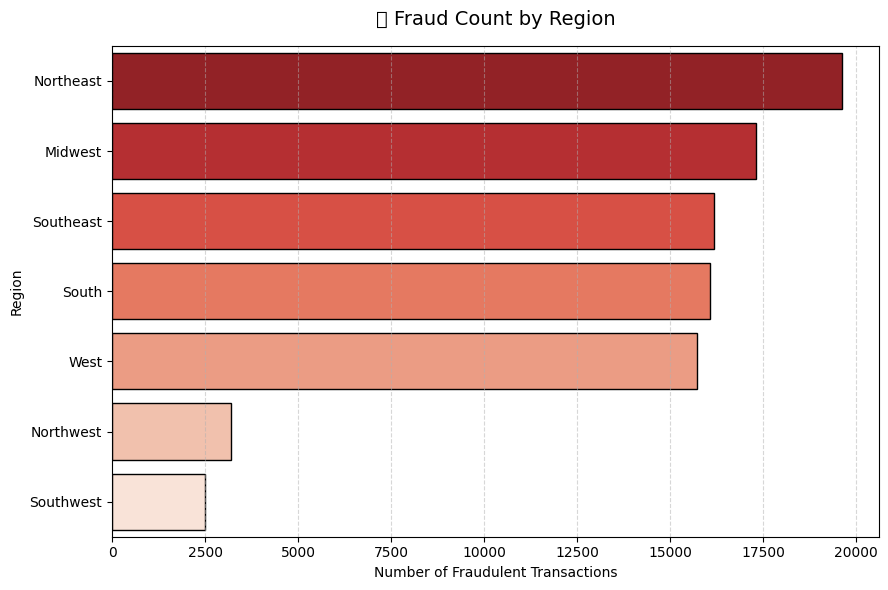

In [59]:
plt.figure(figsize=(9,6))
sns.barplot(
    data=fraud_counts_region.reset_index(),
    x='Fraud Count',
    y='region',
    palette='Reds_r',
    edgecolor='black'
)
plt.title('💳 Fraud Count by Region', fontsize=14, pad=15)
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Region')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [60]:
add_remark(summary_table, "state", "Created region column from state")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,Removed 'fraud_' and clean punc
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,new column job_category with high-level catego...
state,17292422,0,0.0,51,object,Created region column from state
category,17292422,0,0.0,14,object,NaN


In [61]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹Category

In [62]:
df_2020['category'].value_counts()

category
home              3251297
kids_pets         3011880
food_dining       2600082
personal_care     2445132
health_fitness    2157437
entertainment     2153157
travel            1104801
shopping_pos       500863
shopping_net        21821
grocery_pos         21733
misc_net            12228
gas_transport        7605
misc_pos             2877
grocery_net          1509
Name: count, dtype: int64

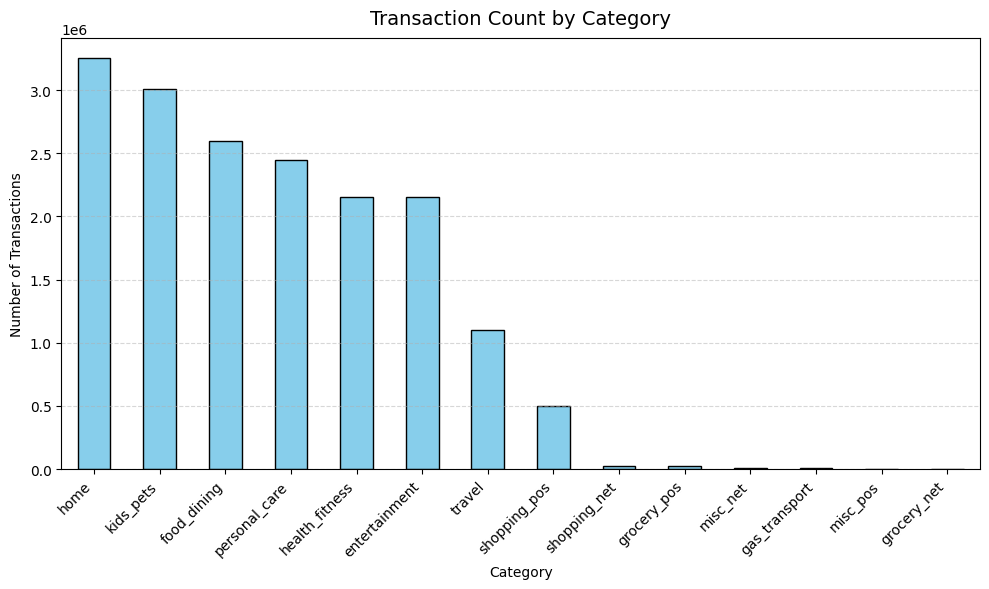

In [63]:
plt.figure(figsize=(10, 6))
df_2020['category'].value_counts().plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)

plt.title('Transaction Count by Category', fontsize=14, pad=10)
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_7116\2428092148.py:14: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\credit-card-fraud-detection-model-FZHIqfLr-py3.13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


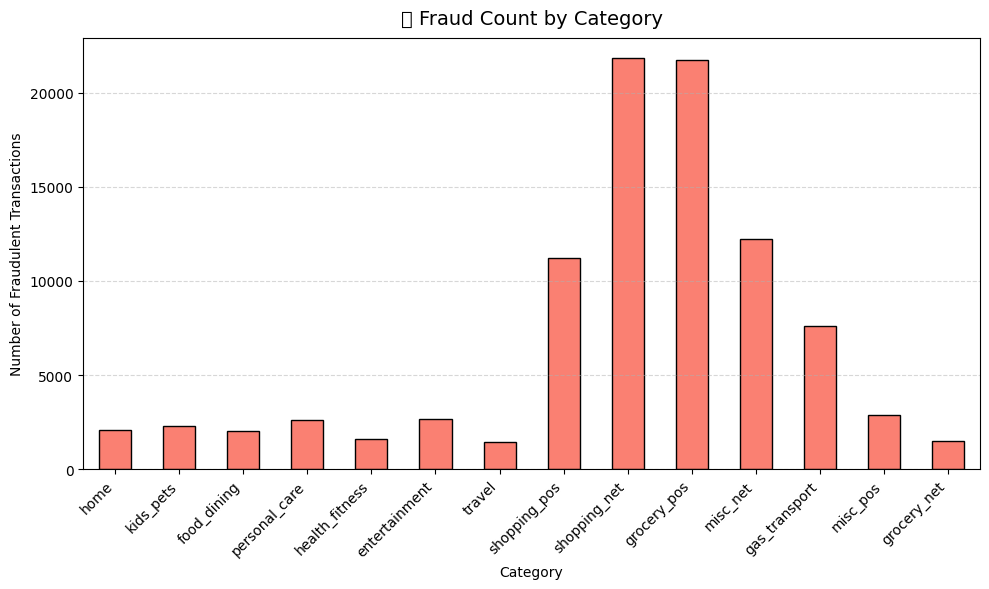

In [64]:
fraud_by_category = (
    df_2020[df_2020['is_fraud'] == 1]['category']
    .value_counts()
    .reindex(df_2020['category'].value_counts().index)  # align order with total
)

plt.figure(figsize=(10, 6))
fraud_by_category.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('💳 Fraud Count by Category', fontsize=14, pad=10)
plt.xlabel('Category')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [65]:
add_remark(summary_table, "category", "keep as is")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,Removed 'fraud_' and clean punc
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,new column job_category with high-level catego...
state,17292422,0,0.0,51,object,Created region column from state
category,17292422,0,0.0,14,object,keep as is


In [66]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN


#### <font color='Navy'> 🔹City

In [67]:
display(df_2020['city'].value_counts().head(10))

city
Houston          174661
Chicago          168414
Brooklyn         146938
Los Angeles      131821
Las Vegas        103031
San Antonio       94633
Miami             93515
New York City     85341
Bronx             82401
Philadelphia      80498
Name: count, dtype: int64

In [68]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 38 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ssn               object        
 1   cc_num            int64         
 2   first             object        
 3   last              object        
 4   gender            category      
 5   street            object        
 6   city              object        
 7   state             object        
 8   zip               int64         
 9   lat               float64       
 10  long              float64       
 11  city_pop          int64         
 12  job               object        
 13  dob               datetime64[ns]
 14  acct_num          int64         
 15  profile           object        
 16  trans_num         object        
 17  trans_date        datetime64[ns]
 18  trans_time        datetime64[ns]
 19  unix_time         int64         
 20  category          object        
 21  amt        

In [69]:
object_cols = df_2020.select_dtypes(include=['object'])

In [70]:
#object cols to categorical:
for col in object_cols.columns:
    df_2020[col] = df_2020[col].astype('category')

In [71]:
df_2020.to_pickle("df_2020_cat_clean.pkl")

In [3]:
df_2020 = pd.read_pickle("df_2020_cat_clean.pkl")

In [4]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 38 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ssn               category      
 1   cc_num            int64         
 2   first             category      
 3   last              category      
 4   gender            category      
 5   street            category      
 6   city              category      
 7   state             category      
 8   zip               int64         
 9   lat               float64       
 10  long              float64       
 11  city_pop          int64         
 12  job               category      
 13  dob               datetime64[ns]
 14  acct_num          int64         
 15  profile           category      
 16  trans_num         category      
 17  trans_date        datetime64[ns]
 18  trans_time        datetime64[ns]
 19  unix_time         int64         
 20  category          category      
 21  amt        

In [5]:
df_2020['trans_time'] = df_2020['trans_time'].dt.hour

In [6]:
def day_time_group(hour: int) -> str:
    """Return the time group based on the hour of the day.

    Args:
        hour (int): Hour of the day, from 0 to 23.

    Returns:
        str: 'Night' for hours 22-3, 'Morning' for hours 4-12, 'Afternoon' for hours 12-21.
    """
    if hour >= 22 or hour < 4:
        return 'Night'
    elif hour >= 4 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 17:
        return 'Afternoon'
    elif hour >= 17 and hour < 22:
        return 'Evening'

In [7]:
df_2020['trans_time_group'] = df_2020['trans_time'].apply(day_time_group)

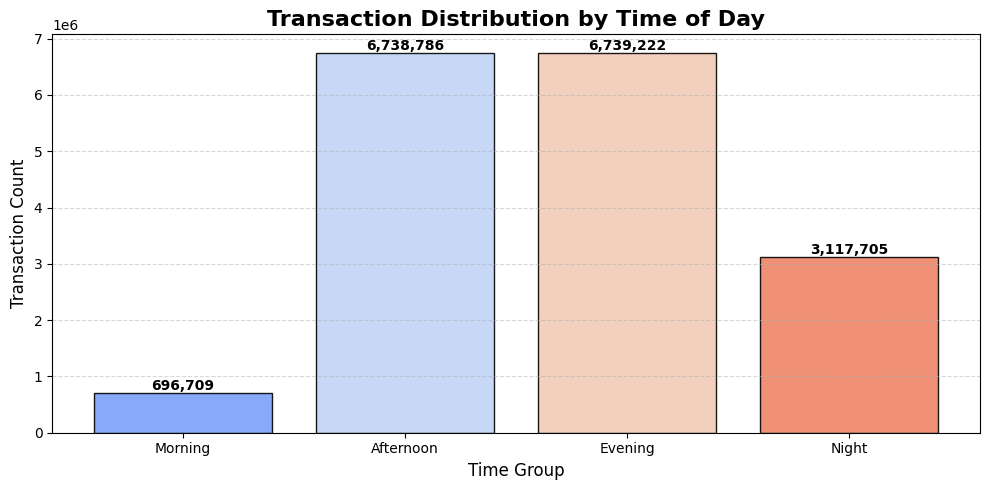

In [8]:
trans_counts = df_2020['trans_time_group'].value_counts().reindex(['Morning', 'Afternoon', 'Evening', 'Night'])

# Create a soft gradient palette
colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(trans_counts)))

plt.figure(figsize=(10, 5))
bars = plt.bar(trans_counts.index, trans_counts.values, color=colors, edgecolor='black', alpha=0.9)

# Add text labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10000, f"{yval:,}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.title("Transaction Distribution by Time of Day", fontsize=16, weight="bold")
plt.xlabel("Time Group", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
df_2020['trans_time_group'] = df_2020['trans_time_group'].astype('category')

In [10]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 39 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ssn               category      
 1   cc_num            int64         
 2   first             category      
 3   last              category      
 4   gender            category      
 5   street            category      
 6   city              category      
 7   state             category      
 8   zip               int64         
 9   lat               float64       
 10  long              float64       
 11  city_pop          int64         
 12  job               category      
 13  dob               datetime64[ns]
 14  acct_num          int64         
 15  profile           category      
 16  trans_num         category      
 17  trans_date        datetime64[ns]
 18  trans_time        int32         
 19  unix_time         int64         
 20  category          category      
 21  amt        

## Non Object Cols:

In [80]:
non_object_cols = df_2020.select_dtypes(exclude=['object','category']).copy()


In [81]:
non_object_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 22 columns):
 #   Column           Dtype         
---  ------           -----         
 0   cc_num           int64         
 1   zip              int64         
 2   lat              float64       
 3   long             float64       
 4   city_pop         int64         
 5   dob              datetime64[ns]
 6   acct_num         int64         
 7   trans_date       datetime64[ns]
 8   trans_time       int32         
 9   unix_time        int64         
 10  amt              float64       
 11  is_fraud         int64         
 12  merch_lat        float64       
 13  merch_long       float64       
 14  trans_year       int32         
 15  trans_month      int32         
 16  trans_quarter    int32         
 17  trans_day        int32         
 18  trans_dayofweek  int32         
 19  trans_hour       int32         
 20  age              int64         
 21  gender_encoded   int8          
dt

In [82]:
summary_table2 = column_summary(non_object_cols)
summary_table2["remark"] = ""

In [83]:
display(summary_table2.sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
merch_long,17292422,0,0.0,13991489,float64,
merch_lat,17292422,0,0.0,11063565,float64,
unix_time,17292422,0,0.0,10472260,int64,
amt,17292422,0,0.0,148733,float64,
cc_num,17292422,0,0.0,18653,int64,
acct_num,17292422,0,0.0,18653,int64,
dob,17292422,0,0.0,13192,datetime64[ns],
zip,17292422,0,0.0,9847,int64,
long,17292422,0,0.0,9706,float64,
lat,17292422,0,0.0,9522,float64,


#### <font color='blue'> 🔹trans_year: </font>
- unique value of 2020 for all rows - drop

In [84]:
print(cols_to_drop)
cols_to_drop.append("trans_year")
print(cols_to_drop)

['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job']
['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job', 'trans_year']


In [85]:
print(cols_to_drop)
cols_to_drop.append("dob")
print(cols_to_drop)

['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job', 'trans_year']
['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job', 'trans_year', 'dob']


In [86]:
add_remark(summary_table2, "trans_year", "remove")
add_remark(summary_table2, "dob", "remove")

,count,nulls,nulls%,cardinality,dtype,remark
merch_long,17292422,0,0.0,13991489,float64,
merch_lat,17292422,0,0.0,11063565,float64,
unix_time,17292422,0,0.0,10472260,int64,
amt,17292422,0,0.0,148733,float64,
cc_num,17292422,0,0.0,18653,int64,
acct_num,17292422,0,0.0,18653,int64,
dob,17292422,0,0.0,13192,datetime64[ns],
zip,17292422,0,0.0,9847,int64,
long,17292422,0,0.0,9706,float64,
lat,17292422,0,0.0,9522,float64,


,count,nulls,nulls%,cardinality,dtype,remark
merch_long,17292422,0,0.0,13991489,float64,
merch_lat,17292422,0,0.0,11063565,float64,
unix_time,17292422,0,0.0,10472260,int64,
amt,17292422,0,0.0,148733,float64,
cc_num,17292422,0,0.0,18653,int64,
acct_num,17292422,0,0.0,18653,int64,
dob,17292422,0,0.0,13192,datetime64[ns],remove
zip,17292422,0,0.0,9847,int64,
long,17292422,0,0.0,9706,float64,
lat,17292422,0,0.0,9522,float64,


In [87]:
display(summary_table2[summary_table2["remark"].isna() | (summary_table2["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
merch_long,17292422,0,0.0,13991489,float64,
merch_lat,17292422,0,0.0,11063565,float64,
unix_time,17292422,0,0.0,10472260,int64,
amt,17292422,0,0.0,148733,float64,
acct_num,17292422,0,0.0,18653,int64,
cc_num,17292422,0,0.0,18653,int64,
zip,17292422,0,0.0,9847,int64,
long,17292422,0,0.0,9706,float64,
lat,17292422,0,0.0,9522,float64,
city_pop,17292422,0,0.0,6023,int64,


#### <font color='Navy'> 🔹lan, lat, lan_merch, lat_merch : </font>

- lat / long: customer’s home location (from their address).
- merch_lat / merch_long: merchant’s location.

In [11]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth's radius in kilometers
    return c * r

df_2020["distance_km"] = haversine(
    df_2020["lat"],
    df_2020["long"],
    df_2020["merch_lat"],
    df_2020["merch_long"]
).astype("float32")


In [14]:
distance_min = df_2020['distance_km'].min()
distance_max = df_2020['distance_km'].max()

print(f"distance Range (km): {distance_min} - {distance_max}")
print(df_2020['distance_km'].nunique())

distance Range (km): 0.014607339166104794 - 151.95594787597656
10982516


In [27]:
#round values to 2 decimal places:
df_temp2 = df_2020['distance_km'].astype('float64').round(2)


In [28]:
df_temp2.head(3)

0    118.63
1     59.07
2    107.19
Name: distance_km, dtype: float64

In [29]:
df_2020['distance_km']= df_2020['distance_km'].astype('float64').round(2)

In [30]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 40 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ssn               category      
 1   cc_num            int64         
 2   first             category      
 3   last              category      
 4   gender            category      
 5   street            category      
 6   city              category      
 7   state             category      
 8   zip               int64         
 9   lat               float64       
 10  long              float64       
 11  city_pop          int64         
 12  job               category      
 13  dob               datetime64[ns]
 14  acct_num          int64         
 15  profile           category      
 16  trans_num         category      
 17  trans_date        datetime64[ns]
 18  trans_time        int32         
 19  unix_time         int64         
 20  category          category      
 21  amt        

In [31]:
df_2020.to_pickle("df_flat.pkl")

In [17]:
df_2020 = pd.read_pickle("df_flat.pkl")

In [18]:
cols_to_drop = ['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job', 'trans_year', 'dob']

In [19]:
cols_to_drop = cols_to_drop + ["lat", "long", "merch_lat", "merch_long"]

In [20]:
print("Final cols to drop:", cols_to_drop)

Final cols to drop: ['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job', 'trans_year', 'dob', 'lat', 'long', 'merch_lat', 'merch_long']


In [21]:
df_clean = df_2020.drop(columns=cols_to_drop)

In [22]:
df_clean.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   cc_num            int64         
 1   gender            category      
 2   city              category      
 3   state             category      
 4   zip               int64         
 5   city_pop          int64         
 6   acct_num          int64         
 7   trans_date        datetime64[ns]
 8   trans_time        int32         
 9   unix_time         int64         
 10  category          category      
 11  amt               float64       
 12  is_fraud          int64         
 13  merchant          category      
 14  trans_month       int32         
 15  trans_quarter     int32         
 16  trans_day         int32         
 17  trans_dayofweek   int32         
 18  trans_hour        int32         
 19  age               int64         
 20  gender_encoded    int8          
 21  age_group  

In [23]:
df_clean.to_pickle("df_clean.pkl")

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   cc_num            int64         
 1   gender            category      
 2   city              category      
 3   state             category      
 4   zip               int64         
 5   city_pop          int64         
 6   acct_num          int64         
 7   trans_date        datetime64[ns]
 8   trans_time        int32         
 9   unix_time         int64         
 10  category          category      
 11  amt               float64       
 12  is_fraud          int64         
 13  merchant          category      
 14  trans_month       int32         
 15  trans_quarter     int32         
 16  trans_day         int32         
 17  trans_dayofweek   int32         
 18  trans_hour        int32         
 19  age               int64         
 20  gender_encoded    int8          
 21  age_group  

In [25]:
df_clean.isnull().sum()

cc_num                   0
gender                   0
city                     0
state                    0
zip                      0
city_pop                 0
acct_num                 0
trans_date               0
trans_time               0
unix_time                0
category                 0
amt                      0
is_fraud                 0
merchant                 0
trans_month              0
trans_quarter            0
trans_day                0
trans_dayofweek          0
trans_hour               0
age                      0
gender_encoded           0
age_group                0
location_profile         0
job_category             0
region              551424
trans_time_group         0
distance_km              0
dtype: int64

In [26]:
#our regoin imputation added some nulls - for now we will drop column and hanle it later in EDA or data clean.
df_clean = df_clean.drop(columns=['region'])


In [ ]:
categorical_time_features = ["trans_month", "trans_quarter", "trans_dayofweek", "trans_hour"]

df_clean[categorical_time_features] = df_clean[categorical_time_features].astype("category")


In [28]:
df_clean.to_pickle("df_clean2.pkl")

In [29]:
df_clean = pd.read_pickle("df_clean2.pkl")

In [31]:
df_clean['zip'] = df_clean['zip'].astype(str)
df_clean['zip'] = df_clean['zip'].str[:5] # make sure zips starting from 0 do not drop it.

# Re-pad with leading zeros if needed (ensures all are 5 digits)
df_clean['zip'] = df_clean['zip'].str.zfill(5)


In [32]:
df_clean['zip'] = df_clean['zip'].astype('category')


In [38]:
df_clean['zip'].value_counts().head(10)



zip
19047    13137
92503    11731
11230    10643
93033    10297
11385    10269
93230     9838
02148     9812
29588     9531
92880     9473
08831     9408
Name: count, dtype: int64

In [39]:
df_clean['zip'].nunique()


9847

In [41]:
# we have too many unique values - lets group them into zip3 regions instead:
df_clean['zip3'] = df_clean['zip'].str[:3].astype('category')


In [42]:
df_clean['zip3'].isna().sum()

np.int64(0)

In [44]:
df_clean['zip3'].nunique()

876

In [43]:
df_clean.drop(columns=['zip'], inplace=True)

In [53]:
df_clean.drop(columns=['trans_date'], inplace=True) # Need to be dropped at data prep - already devided into other columns.

In [47]:
merchant_stats = (
    df_clean.groupby('merchant')['is_fraud']
      .agg(['mean', 'count'])
      .rename(columns={'mean': 'merchant_fraud_rate', 'count': 'merchant_tx_count'})
)

merchant_stats.sort_values(by='merchant_fraud_rate', ascending=True)

C:\Users\User\AppData\Local\Temp\ipykernel_23968\638708772.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby('merchant')['is_fraud']


,merchant_fraud_rate,merchant_tx_count
merchant,,
weber and sons,0.000464,51757
wuckertgoldner,0.000490,65256
koss hansen and lueilwitz,0.000495,64644
botsford and sons,0.000510,64698
hirthebeier,0.000532,43195
...,...,...
barton inc,1.000000,453
bartolettiwunsch,1.000000,143
balistrerinader,1.000000,63


In [49]:
print(df_clean['merchant'].nunique())


693


In [54]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 25 columns):
 #   Column            Dtype   
---  ------            -----   
 0   cc_num            int64   
 1   gender            category
 2   city              category
 3   state             category
 4   city_pop          int64   
 5   acct_num          int64   
 6   trans_time        int32   
 7   unix_time         int64   
 8   category          category
 9   amt               float64 
 10  is_fraud          int64   
 11  merchant          category
 12  trans_month       category
 13  trans_quarter     category
 14  trans_day         int32   
 15  trans_dayofweek   category
 16  trans_hour        category
 17  age               int64   
 18  gender_encoded    int8    
 19  age_group         category
 20  location_profile  category
 21  job_category      category
 22  trans_time_group  category
 23  distance_km       float64 
 24  zip3              category
dtypes: category(14), floa

In [55]:
df_clean.to_pickle("df_clean3.pkl")

In [3]:
df_clean = pd.read_pickle("df_clean3.pkl")

In [4]:
df_clean['trans_day'] = df_clean['trans_day'].astype('category')

### paired data checker:

In [ ]:
# checks whether the SSN (ssn) and credit card number (cc_num) always change together in a DataFrame (df).
def paired_data_checker(df, col1, col2):
    """
    Checks if two columns always change together in a DataFrame.
    Returns True if they always change together, False otherwise.
    """
    paired_changes = df[[col1, col2]].drop_duplicates()
    unique_col1 = df[col1].nunique()
    unique_col2 = df[col2].nunique()
    
    if len(paired_changes) == max(unique_col1, unique_col2):
        print(f"{col1} and {col2} always change together. consider dropping one of them.")
        return
    else:
        print(f"{col1} and {col2} do not always change together.")
        return

# ssn_ccnum_pairs = df[['ssn', 'cc_num']].drop_duplicates()
# if len(ssn_ccnum_pairs) == len(df[['ssn', 'cc_num']].drop_duplicates(subset=['ssn'])):
#     print("ssn and cc_num always change together. Check whether to delete the column.")
# else:
#     print("ssn and cc_num do not always change together.")
# #############  df = df.drop(columns=['ssn']) ############    

In [ ]:
paired_data_checker(df, 'ssn', 'cc_num')
paired_data_checker(df, 'acct_num', 'cc_num')

## 2) Extraction of additional data:

In [ ]:
category_stats = (
    df.groupby('merchant')
      .agg(total_transactions=('merchant', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index().sort_values(by='total_fraud', ascending=False))

print(category_stats)